# Testing Individual Images
### Use techniques we've already learned in class to try and make progress on identifying roads

Imports

In [42]:
import skimage.io as skio
import skimage.util as sku
import skimage.color as skol
from skimage import filters, feature, transform
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

### Function for calculating label accuracy

In [3]:
def seg_metrics(segmented_image, image_label):
    #returns:
    # percent of labeled pixels that are truth - correctly identified pixels
    # percent of unlabeled pixels that are truth - missed pixels
    return 1

In [9]:
image_filepath = "./data/massRoads/tiff"
# /train/... for images and /train_labels/... for labels

In [10]:
image = skio.imread(image_filepath + "/train/10078675_15.tiff")
image_label = skio.imread(image_filepath + "/train_labels/10078675_15.tif")

In [11]:
np.unique(image_label)

array([  0, 255], dtype=uint8)

Cropping Image for testing

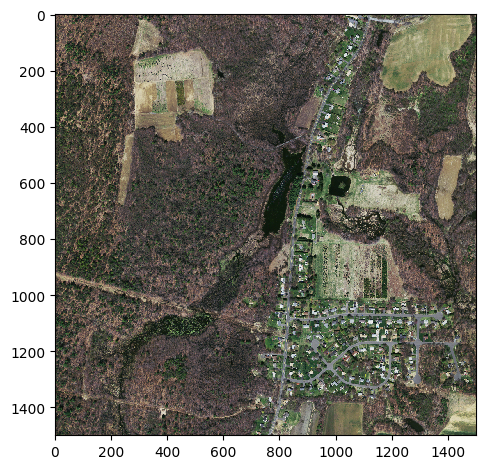

In [12]:
skio.imshow(image)

In [13]:
x1, y1 = 750, 900
x2, y2 = 1500, 1500

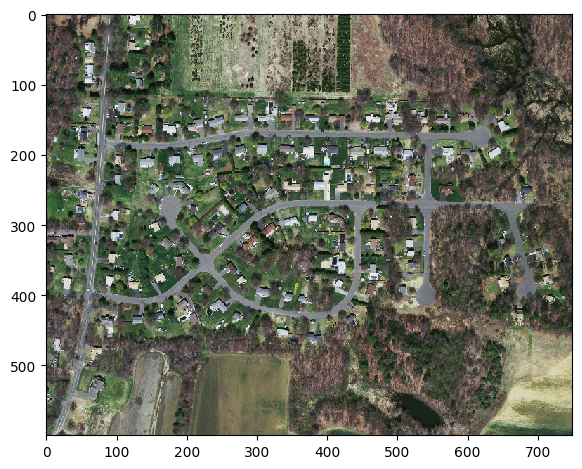

In [14]:
image = image[y1:y2, x1:x2, :]
skio.imshow(image)

In [15]:
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

### K means clustering from OpenCV
https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/

In [16]:
#the below line of code defines the criteria for the algorithm to stop running, 
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy) 
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering with number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

In [17]:
np.unique(segmented_image)

array([ 51,  57,  64,  90, 109, 148, 164, 165], dtype=uint8)

That's weird, I chose 2 clusters but we have more than two values in the segmented image, maybe this is just for visualization?

In [22]:
# plt.imshow(segmented_image)

### K means from sklearn

In [19]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(pixel_vals)

Initialization complete
Iteration 0, inertia 1082049792.0.
Iteration 1, inertia 578104320.0.
Iteration 2, inertia 540939648.0.
Iteration 3, inertia 533685632.0.
Iteration 4, inertia 530920896.0.
Iteration 5, inertia 529365952.0.
Iteration 6, inertia 528246432.0.
Iteration 7, inertia 527392256.0.
Iteration 8, inertia 526624224.0.
Iteration 9, inertia 526035840.0.
Iteration 10, inertia 525508672.0.
Iteration 11, inertia 525062976.0.
Iteration 12, inertia 524693152.0.
Iteration 13, inertia 524403072.0.
Iteration 14, inertia 524111616.0.
Iteration 15, inertia 523881728.0.
Iteration 16, inertia 523677280.0.
Iteration 17, inertia 523495456.0.
Iteration 18, inertia 523327872.0.
Iteration 19, inertia 523174720.0.
Iteration 20, inertia 523050560.0.
Iteration 21, inertia 522954048.0.
Iteration 22, inertia 522867200.0.
Iteration 23, inertia 522795200.0.
Iteration 24, inertia 522739520.0.
Converged at iteration 24: center shift 0.14998295903205872 within tolerance 0.17871517333984377.


In [20]:
sk_segmented_image = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


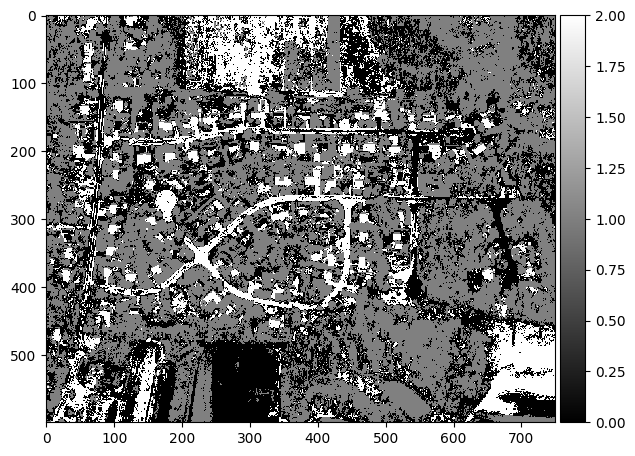

In [21]:
skio.imshow(sk_segmented_image, cmap='gray')

### Let's try to input a few more things into the model

Let's try to put a horizontal and vertically run edge detection using Sobel kernels

In [23]:
image_gray = skol.rgb2gray(image)

# Define Sobel kernels
sobel_horizontal = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])

sobel_vertical = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

# Perform convolutions
edges_horizontal = convolve2d(image_gray, sobel_horizontal, mode='same', boundary='symm')
edges_vertical = convolve2d(image_gray, sobel_vertical, mode='same', boundary='symm')

# Calculate the magnitude of the gradient
edges = np.sqrt(np.square(edges_horizontal) + np.square(edges_vertical))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


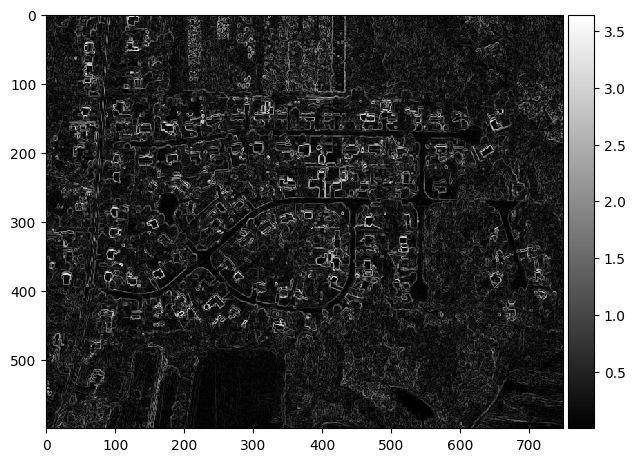

In [24]:
skio.imshow(edges, cmap='gray')

Let's see if canny edge detection works better

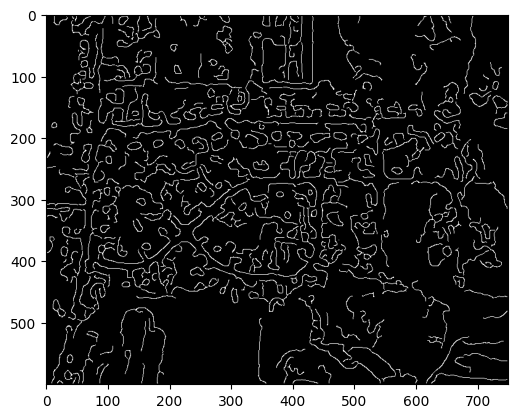

In [26]:
# Calculation Canny gradient
canny_edges = feature.canny(image_gray, sigma=3)

plt.imshow(canny_edges, cmap='gray')

Now lets add this new channel to the image and see what happens

In [28]:
image_with_canny = np.dstack((image, canny_edges.astype(np.uint8) * 255))

In [29]:
feature_vals = image_with_canny.reshape((-1,4))
feature_vals = np.float32(feature_vals)

In [30]:
feature_vals.shape

(450000, 4)

In [39]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(feature_vals)

Initialization complete
Iteration 0, inertia 1168527104.0.
Iteration 1, inertia 992265216.0.
Iteration 2, inertia 975117312.0.
Iteration 3, inertia 969393152.0.
Iteration 4, inertia 967448320.0.
Iteration 5, inertia 966801152.0.
Iteration 6, inertia 966579072.0.
Iteration 7, inertia 966514304.0.
Converged at iteration 7: center shift 0.07635211944580078 within tolerance 0.225528662109375.


In [40]:
sk_segmented_image = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


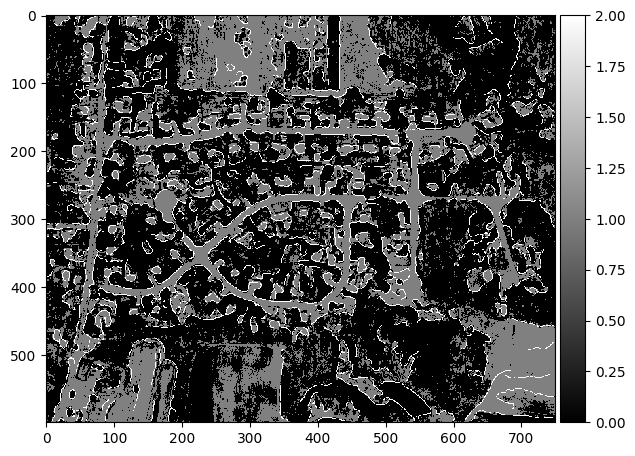

In [41]:
skio.imshow(sk_segmented_image, cmap='gray')

### Let's try a bigger edge detection kernel, maybe it will only detect longer edges

In [ ]:
image_gray = skol.rgb2gray(image)

# Define Sobel kernels
long_horizontal = np.array([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
                             [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
                             [ 1,  1,  1,  1,  1,  1,  1,  1,  1]])

long_vertical = np.array([[-1, 0, 1],
                           [-1, 0, 1],
                           [-1, 0, 1],
                           [-1, 0, 1],
                           [-1, 0, 1],
                           [-1, 0, 1],
                           [-1, 0, 1],
                           [-1, 0, 1],
                           [-1, 0, 1]])

# Perform convolutions
l_edges_horizontal = convolve2d(image_gray, long_horizontal, mode='same', boundary='symm')
l_edges_vertical = convolve2d(image_gray, long_vertical, mode='same', boundary='symm')

# Calculate the magnitude of the gradient
long_edges = np.sqrt(np.square(edges_horizontal) + np.square(edges_vertical))

Text(0.5, 1.0, 'Edges')

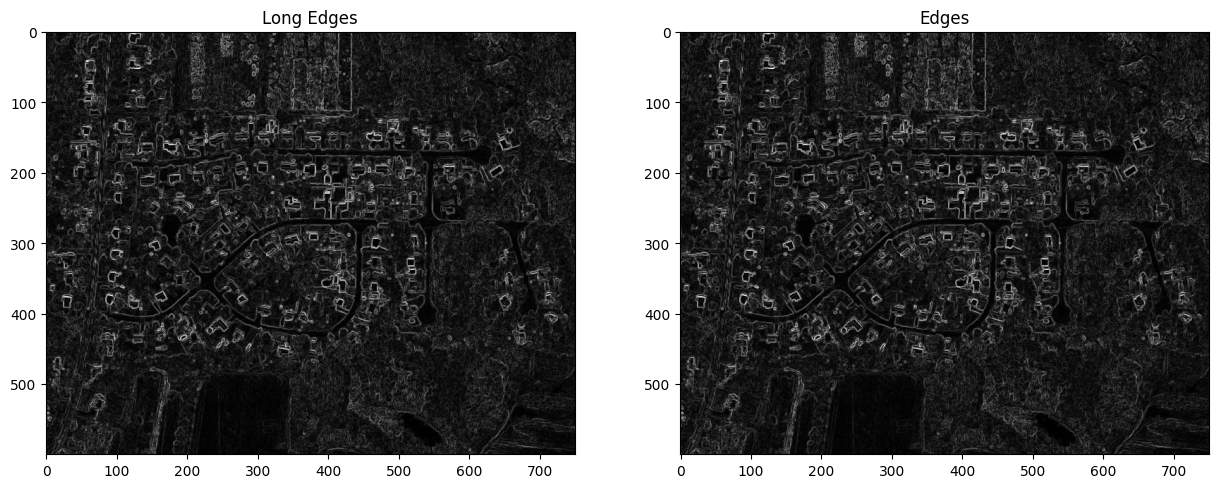

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (15,10))

axes[0].imshow(long_edges, cmap='gray')
axes[0].set_title("Long Edges")
axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Edges")

This is the exact same thing, nice try

### Hough Transform for detecting straight edges

In [37]:
lines = transform.probabilistic_hough_line(canny_edges, threshold=20, line_length=20, line_gap=3)

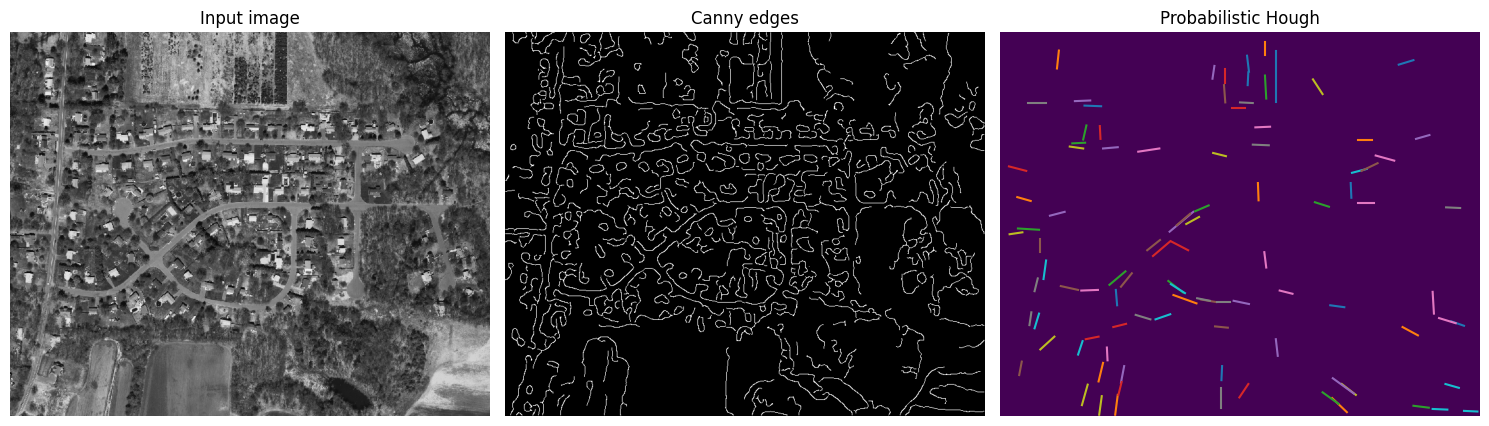

In [38]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(canny_edges, cmap='gray')
ax[1].set_title('Canny edges')

ax[2].imshow(canny_edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image_gray.shape[1]))
ax[2].set_ylim((image_gray.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()